## Setup

## Data Pre-Processing

In [1]:
#!pip install --upgrade ipykernel
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
#!pip install pyLDAvis
#!pip install spaCy
import nltk
import re
import gensim
import pandas as pd
import numpy as np
import spacy
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns

#nltk.download('stopwords')
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')


In [3]:
#read in CSV files
#ROCK
df = pd.read_csv('classic_rock.csv') #321 songs, 19 features

df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'title', 'first_artist',
       'all_artists', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'artist', 'song', 'lyrics',
       'lyrics_cleaned'],
      dtype='object')

In [4]:
final_lyrics = []
all_words = []
df['filtered_lyrics'] = ''


# try:
for each in range(len(df)):
    try:
        cleaned_lyrics = (re.sub(r"[,.:;?'\")(!]\d", ' ', str(df.loc[each,'lyrics_cleaned']))).lower()
    except:
        cleaned_lyrics = 'no'

    lemmatized_lyrics = lemmatizer.lemmatize(cleaned_lyrics)
    tokenized_lyrics = word_tokenize(lemmatized_lyrics)
    filtered_lyrics = [w for w in tokenized_lyrics if not w in stop_words]
    filtered_lyrics = [w for w in filtered_lyrics if len(w) > 2]
    
    for i in filtered_lyrics:
        all_words.append(i)

    final_lyrics.append(filtered_lyrics)

    filtered_lyrics = ' '.join(filtered_lyrics)
    df.loc[each, 'filtered_lyrics'] = filtered_lyrics


In [5]:
df.shape

(294, 23)

## Sklearn topic modeling

In [6]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df.loc[:, 'filtered_lyrics'])

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  8.727477477477477 %


In [9]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=4,            # Number of topics
                                      max_iter=25,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=102,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', max_iter=25, n_components=4,
                          n_jobs=-1, random_state=102)


In [10]:
# 4
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
#panel

In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -96920.52842699496
Perplexity:  178.49836831649975
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 25,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 102,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [12]:
# grid search

# Define Search Param
search_params = {'n_components': [4, 5, 6], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6]})

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 4}
Best Log Likelihood Score:  -21693.733786558052
Model Perplexity:  173.83204168983661


In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Song" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
#df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
#df_document_topics

In [15]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
#df_topic_keywords.head()

In [16]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Songs']
df_topic_distribution

,Topic Num,Num Songs
0,0,93
1,2,87
2,1,66
3,3,48


In [17]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  32.166843
0        1.782994 -295.079681       2        1  31.129361
1      220.811432 -343.832123       3        1  21.583355
3       50.533993  -76.050934       4        1  15.120440, topic_info=       Term        Freq       Total Category  logprob  loglift
177     ooh  351.000000  351.000000  Default  30.0000  30.0000
293    yeah  351.000000  351.000000  Default  29.0000  29.0000
127    know  671.000000  671.000000  Default  28.0000  28.0000
155    love  401.000000  401.000000  Default  27.0000  27.0000
278     wan  216.000000  216.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
32   chorus   41.867911  350.135585   Topic4  -4.2123  -0.2347
127    know   42.450324  671.060934   Topic4  -4.1985  -0.8714
188     pre   29.502044  206.719496   Topic4  -4.5624  -0.0578
175   night   24.260078  131.786699   Topic4  -4.7580   0.1968
247    tell   24.148617  148.679045   Topic4  -4.7626   0.0716

[235 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         2  0.264555    alive
1         3  0.595249    alive
1         4  0.132278    alive
2         1  0.117219  alright
2         3  0.073262  alright
...     ...       ...      ...
293       4  0.005683     yeah
294       3  0.319491      yes
294       4  0.638982      yes
295       2  0.135549    young
295       3  0.858475    young

[517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [18]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=30)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29
Topic 0,know,want,let,got,time,chorus,like,cause,feel,make,...,heart,things,long,goes,inside,world,die,life,wrong,stop
Topic 1,ooh,yeah,way,got,like,night,head,hey,life,told,...,turn,outro,look,burn,pre,need,young,bridge,comes,stay
Topic 2,love,like,come,wan,chorus,got,time,yeah,know,feel,...,new,cause,sun,coming,way,rock,dance,black,bridge,gone
Topic 3,walk,sing,say,really,used,alright,good,away,time,right,...,dream,pre,song,tonight,fight,man,looking,late,night,tell


In [19]:
# # Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# # Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# # X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# # Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# # Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.7   0.33  0.59  0.23]
 [-0.63  0.01  0.77 -0.05]]
Perc of Variance Explained: 
 [0.04 0.44]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

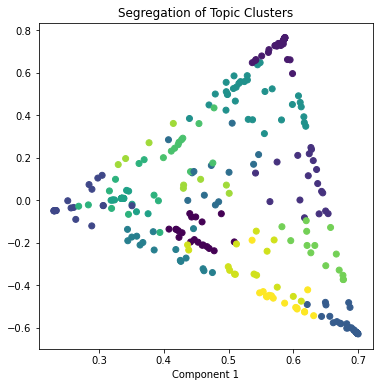

In [20]:
# # Plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
#plt.legend(loc="upper left")

In [21]:
df_post_topic = pd.concat([df,df_document_topic.reset_index(drop = True)], axis = 1)
#df_post_topic.head()

## Sentiment Analysis

In [22]:
#!pip install vaderSentiment

In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [24]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [25]:
df_post_topic.loc[:,'sentiment'] = df_post_topic.loc[:,'filtered_lyrics'].map(lambda x:sentiment_analyzer_scores(x))

In [26]:
df_post_topic.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'title', 'first_artist',
       'all_artists', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'artist', 'song', 'lyrics',
       'lyrics_cleaned', 'filtered_lyrics', 'Topic0', 'Topic1', 'Topic2',
       'Topic3', 'dominant_topic', 'sentiment'],
      dtype='object')

In [27]:
#df_post_topic = df.copy()
#df_post_topic['dominant_topic'] = dominant_topic

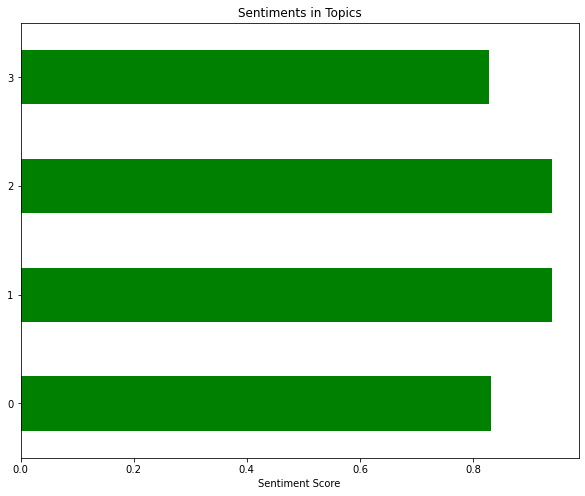

In [28]:
import numpy as np
plt.figure(figsize=(10,8))
df_post_topic.groupby('dominant_topic')['sentiment'].median().plot(kind='barh', color=(df_post_topic.groupby('dominant_topic')['sentiment'].mean() > 0).map({True: 'g',False: 'r'}));
plt.xlabel('Sentiment Score');
plt.ylabel('');
plt.title('Sentiments in Topics');
#plt.yticks(np.arange(4), ('Explicit','Love/Emotional','Reflective/Upbeat','Breakfree/Celebrating Yourself'));

In [29]:
df_post_topic.to_csv('data_with_topic_and_sentiment.csv', index = False)

In [30]:
import pandas as pd
df = pd.read_csv('data_with_topic_and_sentiment.csv')

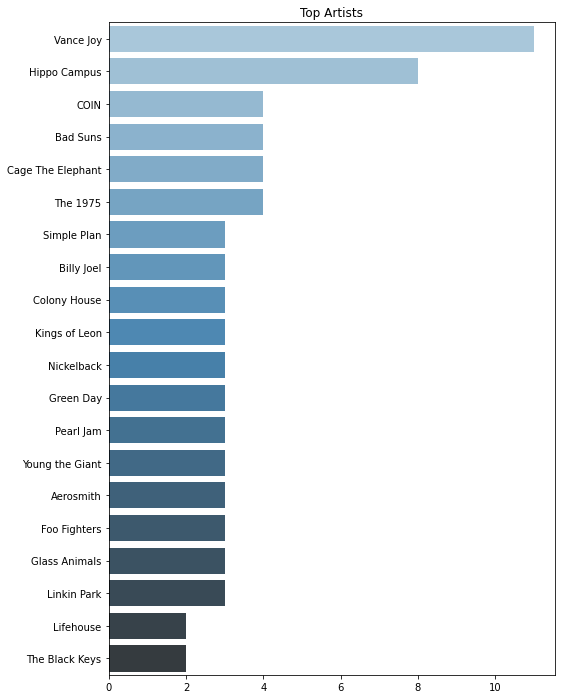

In [31]:
import seaborn as sns; 
plt.figure(figsize=(8,12))
plt.title("Top Artists")
ax = sns.barplot(y=df['first_artist'].value_counts()[:20].index, x=df['first_artist'].value_counts()[:20].values, palette="Blues_d", orient='h')

In [32]:
# word cloud
from nltk.util import ngrams
from collections import Counter

unigram = Counter(ngrams(all_words, 1))
output = pd.DataFrame.from_dict(unigram, orient='index').reset_index()

output.columns = ['Word', 'Count']
output = output.sort_values(by = ['Count'], ascending = False)
for each in range(len(output)):
    output.loc[each,'Word'] = str(output.loc[each,'Word'])[2:-3]
output.reset_index(inplace = True)
output = output.drop('index', axis = 1)
output.to_csv('ngram.csv')
output['Word'][:10]

0     n't
1    know
2     're
3    like
4     got
5    love
6     'll
7     get
8    yeah
9    time
Name: Word, dtype: object

In [33]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'title', 'first_artist',
       'all_artists', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'artist', 'song', 'lyrics',
       'lyrics_cleaned', 'filtered_lyrics', 'Topic0', 'Topic1', 'Topic2',
       'Topic3', 'dominant_topic', 'sentiment'],
      dtype='object')

## TF-IDF

In [34]:
df_post_topic = df.copy()
df_post_topic.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'title', 'first_artist',
       'all_artists', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'artist', 'song', 'lyrics',
       'lyrics_cleaned', 'filtered_lyrics', 'Topic0', 'Topic1', 'Topic2',
       'Topic3', 'dominant_topic', 'sentiment'],
      dtype='object')

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caseyscomputer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/caseyscomputer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
cv=CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2), stop_words='english', max_features=1250)
word_count_vector=cv.fit_transform(df_post_topic.filtered_lyrics.values)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(word_count_vector)


# Recommender - based on lyrics


In [37]:
#based on TF-IDF user inputs a song and we give them recommendations
from sklearn.metrics.pairwise import linear_kernel

#index = the songs index
#make more user friendly
index=10
cosine_similarities = linear_kernel(tf_idf_vector[index:index+1], tf_idf_vector).flatten()
related_song_indices = cosine_similarities.argsort()[:-6:-1]
recom=list(related_song_indices)

print('Song I want recommendations for:')
print(df_post_topic['title'][index:index+1])
print(' ')
print(' ')
print('Recommendations:')
print(' ')
for i in recom:
  print(df_post_topic.iloc[[i]][['title', 'first_artist']] )


Song I want recommendations for:
10    Back In My Head Again
Name: title, dtype: object
 
 
Recommendations:
 
                    title first_artist
10  Back In My Head Again   Levi Evans
             title first_artist
34  All In My Head  Reece Young
                           title first_artist
33  Can't Get You Out of My Head  Johnny Goth
        title first_artist
17  Coke Nose        Caspr
             title    first_artist
119  Day Glow Fire  Future Islands


# Feature Importance

In [38]:
new_df = df.copy()
new_df[:3]
new_df.drop(columns=['song','artist','Unnamed: 0','id','title','first_artist','all_artists','lyrics','time_signature','lyrics_cleaned','filtered_lyrics'], inplace = True)

In [39]:
new_df.columns

Index(['Unnamed: 0.1', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'Topic0', 'Topic1', 'Topic2', 'Topic3', 'dominant_topic',
       'sentiment'],
      dtype='object')

In [40]:
new_df['danceability'] = np.log(new_df['danceability'])
new_df['duration_ms'] = new_df['duration_ms']/60000
new_df['sentiment_positive'] = (new_df['sentiment']>0.7).astype(int)
new_df['sentiment_negative'] = (new_df['sentiment']<-0.7).astype(int)
new_df['sentiment_neutral'] = (~(new_df['sentiment_positive'] | new_df['sentiment_negative'])).astype(int)
new_df = new_df[~new_df.isin([np.nan, np.inf, -np.inf]).any(1)]
new_df.head()

,Unnamed: 0.1,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,...,duration_ms,Topic0,Topic1,Topic2,Topic3,dominant_topic,sentiment,sentiment_positive,sentiment_negative,sentiment_neutral
0,640,-0.567396,0.481,11,-8.787,1,0.2920,0.000000,0.2540,0.242,...,2.456883,0.42,0.49,0.08,0.00,1,0.9928,1,0,-2
1,641,-0.562119,0.850,2,-4.655,1,0.0181,0.000528,0.1230,0.329,...,3.473767,0.22,0.11,0.67,0.00,2,0.9908,1,0,-2
2,642,-0.335473,0.697,9,-5.097,0,0.2310,0.000004,0.0984,0.792,...,2.353783,0.00,0.99,0.00,0.00,1,-0.9978,0,1,-2
3,646,-0.502527,0.817,11,-4.586,0,0.0010,0.691000,0.0954,0.128,...,4.077950,0.01,0.97,0.01,0.01,1,0.3895,0,0,-1
4,647,-0.522561,0.989,11,-4.291,1,0.0115,0.254000,0.2160,0.419,...,2.837450,0.99,0.00,0.00,0.00,0,0.9788,1,0,-2


## can change y variable depending on which attribute you want to predict feature importance

In [41]:
y = new_df['danceability']
X = new_df.loc[:,new_df.columns !='danceability']
# X.drop(columns = ['followers','artist_popularity','Topic0','Topic1', 'Topic2', 'Topic3','dominant_topic','sentiment','sentiment_positive','sentiment_negative','sentiment_neutral'],inplace = True)

## predictive model

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
regr = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=500)
regr.fit(X, y)

r2_score(y, regr.predict(X), sample_weight=None)

0.8836509827140875

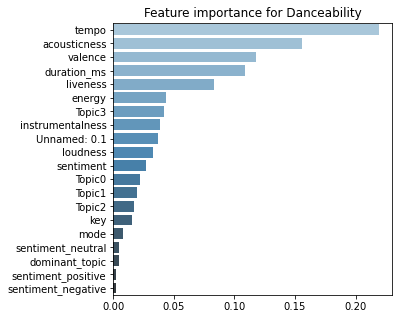

/Users/caseyscomputer/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/caseyscomputer/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/caseyscomputer/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/caseyscomputer/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/caseyscomputer/opt/anaconda3/lib/

In [43]:
# Feature importannce
import seaborn as sns; 
ft_imp = pd.Series(data=regr.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(5,5))
plt.title("Feature importance for Danceability")
ax = sns.barplot(y=ft_imp.index, x=ft_imp.values, palette="Blues_d", orient='h')

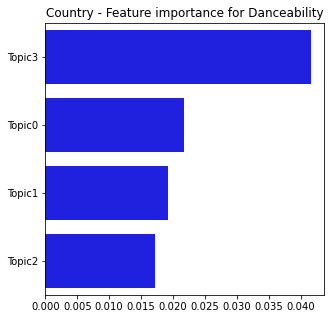

In [44]:
# Feature importannce 
ft_imp = pd.Series(data=regr.feature_importances_, index=X.columns).sort_values(ascending=False)

ft_imp2 = ft_imp.sort_index(ascending=False)
ft_imp2 = ft_imp2[16:].sort_values(ascending=False)

plt.figure(figsize=(5,5))
plt.title("Country - Feature importance for Danceability")
ax = sns.barplot(y=ft_imp2.index, x=ft_imp2.values, color="Blue", orient='h')
#plt.yticks(np.arange(4), ('Love','Partying','Small Town','Heartbreak'));